# Imports

In [65]:
#import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import os
import wfdb
from scipy import signal
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
#from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import neurokit2 as nk
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import butter, lfilter, freqz, iirnotch

import tensorflow as tf
from tensorflow.keras import layers

# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.expand_frame_repr', False)  # Disable wrapping
# pd.set_option('display.max_colwidth', None)  # Show full contents of each cell

pd.reset_option('display.max_columns')  # Show all columns
pd.reset_option('display.expand_frame_repr')  # Disable wrapping
pd.reset_option('display.max_colwidth')  # Show full contents of each cell


# Load data


In [66]:
# import os
# import pandas as pd
# import wfdb

# # Load the CSV file
# superclass_df = pd.read_csv('superclass.csv')

# # Initialize empty arrays to store the data
# data = []

# # Specify the root directory
# root_dir = '../ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'

# # Loop over all records in the DataFrame
# for idx, row in superclass_df.iterrows():
#     if (idx+1)%100 == 0:
#         print(f"Processing record {idx+1}/{len(superclass_df)}")
#     # Get filename without extension
#     filename = os.path.splitext(row['filename_lr'])[0]

#     # Construct the full path
#     full_path = os.path.join(root_dir, filename)

#     # Load the raw ECG signal data from the .dat file
#     dat, fields = wfdb.rdsamp(full_path)

#     # Load the labels data from the .hea file
#     hea = wfdb.rdheader(full_path)

#     # Add data to the list
#     data.append({
#         'record_name': filename,
#         'superclass': row['diagnostic_superclass'],
#         'signal': dat,
#         'age': row['age'],
#         'sex': row['sex']
#     })

# # Convert the list to a DataFrame
# df = pd.DataFrame(data)

# # Save the DataFrame
# df.to_pickle('df_processed.pkl')

df = pd.read_pickle('df_processed.pkl')
df

,record_name,superclass,signal,age,sex
0,records100/00000/00001_lr,['NORM'],"[[-0.119, -0.055, 0.064, 0.086, -0.091, 0.004,...",56.0,1
1,records100/00000/00002_lr,['NORM'],"[[0.004, 0.138, 0.134, -0.072, -0.065, 0.136, ...",19.0,0
2,records100/00000/00003_lr,['NORM'],"[[-0.029, -0.079, -0.049, 0.054, 0.011, -0.064...",37.0,1
3,records100/00000/00004_lr,['NORM'],"[[-0.054, -0.138, -0.083, 0.096, 0.015, -0.11,...",24.0,0
4,records100/00000/00005_lr,['NORM'],"[[-0.034, -0.574, -0.54, 0.304, 0.253, -0.556,...",19.0,1
...,...,...,...,...,...
16239,records100/21000/21833_lr,['STTC'],"[[-0.052, -0.034, 0.018, 0.043, -0.034, -0.008...",67.0,1
16240,records100/21000/21834_lr,['NORM'],"[[-0.05, -0.013, 0.036, 0.031, -0.042, 0.011, ...",300.0,0
16241,records100/21000/21835_lr,['STTC'],"[[0.038, 0.024, -0.014, -0.03, 0.026, 0.005, 0...",59.0,1
16242,records100/21000/21836_lr,['NORM'],"[[-0.057, -0.057, 0.0, 0.057, -0.028, -0.028, ...",64.0,1


# Preprocessing

## downsampling NORM class

In [67]:
# Filter out the "NORM" class

norm_df = df[df['superclass'] == '[\'NORM\']']

# Randomly sample 6000 records from the "NORM" class to be removed
to_remove = norm_df.sample(6000, random_state=1)

# Remove these from the original df
df = df.drop(to_remove.index)
df


,record_name,superclass,signal,age,sex
0,records100/00000/00001_lr,['NORM'],"[[-0.119, -0.055, 0.064, 0.086, -0.091, 0.004,...",56.0,1
2,records100/00000/00003_lr,['NORM'],"[[-0.029, -0.079, -0.049, 0.054, 0.011, -0.064...",37.0,1
7,records100/00000/00008_lr,['MI'],"[[-0.041, -0.08, -0.039, 0.06, -0.001, -0.06, ...",48.0,0
9,records100/00000/00010_lr,['NORM'],"[[-0.065, -0.117, -0.053, 0.091, -0.006, -0.08...",22.0,1
11,records100/00000/00012_lr,['NORM'],"[[0.079, 0.163, 0.084, -0.121, -0.003, 0.123, ...",43.0,1
...,...,...,...,...,...
16235,records100/21000/21826_lr,['MI'],"[[-0.031, -0.001, 0.03, 0.016, -0.031, 0.014, ...",82.0,1
16236,records100/21000/21830_lr,['NORM'],"[[-0.085, 0.079, 0.163, 0.003, -0.124, 0.121, ...",86.0,0
16238,records100/21000/21832_lr,['CD'],"[[-0.076, -0.029, 0.046, 0.052, -0.061, 0.008,...",63.0,0
16239,records100/21000/21833_lr,['STTC'],"[[-0.052, -0.034, 0.018, 0.043, -0.034, -0.008...",67.0,1


## Upsample lowest class

In [68]:
from sklearn.utils import resample

# Separate the 'HYP' class
hyp_df = df[df['superclass'] == '[\'HYP\']']

# Determine how many instances you need to resample
n_samples = 2000  # adjust this value as needed

# Resample the 'HYP' class
hyp_upsampled = resample(hyp_df, 
                         replace=True,  # sample with replacement
                         n_samples=n_samples,  # to match number in majority class
                         random_state=1)  # reproducible results

# Combine the upsampled 'HYP' class with the original dataframe
df = pd.concat([df[df['superclass'] != 'HYP'], hyp_upsampled])
df = df.reset_index(drop=True)

df



,record_name,superclass,signal,age,sex
0,records100/00000/00001_lr,['NORM'],"[[-0.119, -0.055, 0.064, 0.086, -0.091, 0.004,...",56.0,1
1,records100/00000/00003_lr,['NORM'],"[[-0.029, -0.079, -0.049, 0.054, 0.011, -0.064...",37.0,1
2,records100/00000/00008_lr,['MI'],"[[-0.041, -0.08, -0.039, 0.06, -0.001, -0.06, ...",48.0,0
3,records100/00000/00010_lr,['NORM'],"[[-0.065, -0.117, -0.053, 0.091, -0.006, -0.08...",22.0,1
4,records100/00000/00012_lr,['NORM'],"[[0.079, 0.163, 0.084, -0.121, -0.003, 0.123, ...",43.0,1
...,...,...,...,...,...
12239,records100/11000/11847_lr,['HYP'],"[[-0.01, -0.07, -0.06, 0.04, 0.025, -0.065, -0...",71.0,1
12240,records100/01000/01851_lr,['HYP'],"[[0.125, 0.342, 0.218, -0.234, -0.047, 0.28, -...",79.0,1
12241,records100/08000/08766_lr,['HYP'],"[[-0.001, -0.14, -0.138, 0.071, 0.068, -0.139,...",60.0,1
12242,records100/15000/15470_lr,['HYP'],"[[0.012, 0.035, 0.023, -0.023, -0.006, 0.028, ...",72.0,0


## One Hot

In [69]:
# Make sure each label is in a separate list
df['superclass'] = df['superclass'].apply(lambda x: [x] if isinstance(x, str) else x)

mlb = MultiLabelBinarizer()
label_encoded = mlb.fit_transform(df['superclass'])
df_encoded = pd.concat([df.drop('superclass', axis=1), pd.DataFrame(label_encoded, columns=mlb.classes_)], axis=1)

df_encoded


,record_name,signal,age,sex,['CD'],['HYP'],['MI'],['NORM'],['STTC']
0,records100/00000/00001_lr,"[[-0.119, -0.055, 0.064, 0.086, -0.091, 0.004,...",56.0,1,0,0,0,1,0
1,records100/00000/00003_lr,"[[-0.029, -0.079, -0.049, 0.054, 0.011, -0.064...",37.0,1,0,0,0,1,0
2,records100/00000/00008_lr,"[[-0.041, -0.08, -0.039, 0.06, -0.001, -0.06, ...",48.0,0,0,0,1,0,0
3,records100/00000/00010_lr,"[[-0.065, -0.117, -0.053, 0.091, -0.006, -0.08...",22.0,1,0,0,0,1,0
4,records100/00000/00012_lr,"[[0.079, 0.163, 0.084, -0.121, -0.003, 0.123, ...",43.0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
12239,records100/11000/11847_lr,"[[-0.01, -0.07, -0.06, 0.04, 0.025, -0.065, -0...",71.0,1,0,1,0,0,0
12240,records100/01000/01851_lr,"[[0.125, 0.342, 0.218, -0.234, -0.047, 0.28, -...",79.0,1,0,1,0,0,0
12241,records100/08000/08766_lr,"[[-0.001, -0.14, -0.138, 0.071, 0.068, -0.139,...",60.0,1,0,1,0,0,0
12242,records100/15000/15470_lr,"[[0.012, 0.035, 0.023, -0.023, -0.006, 0.028, ...",72.0,0,0,1,0,0,0


## Distribution of diseases SNOMED

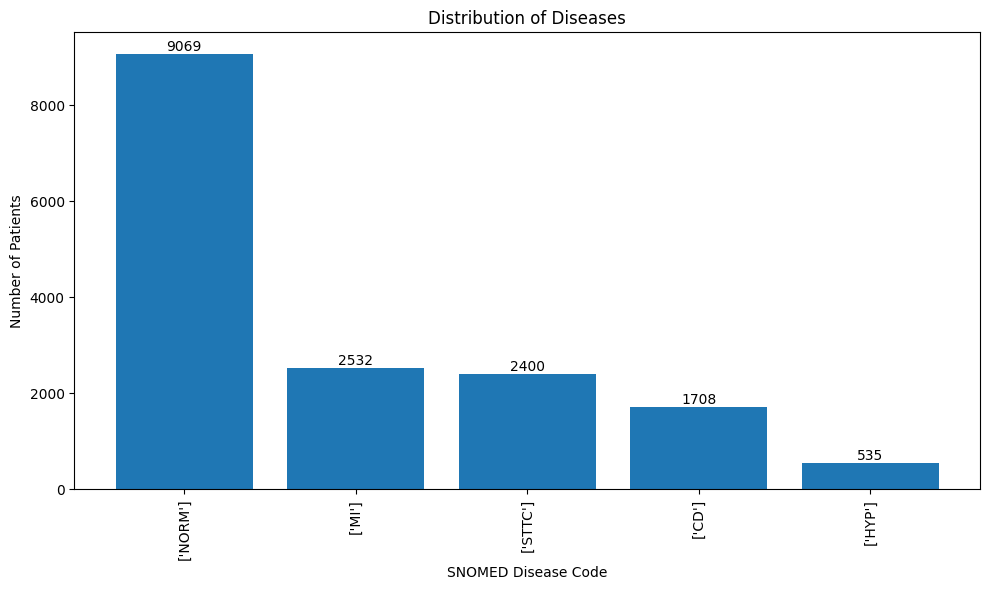

In [70]:
plt.figure(figsize=(10, 6))

# Bar chart
bars = plt.bar(disease_counts_sorted.index.astype(str), disease_counts_sorted.values)

# Add data values to the top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, int(yval), ha='center', va='bottom')

plt.xlabel('SNOMED Disease Code')
plt.ylabel('Number of Patients')
plt.title('Distribution of Diseases')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## test display

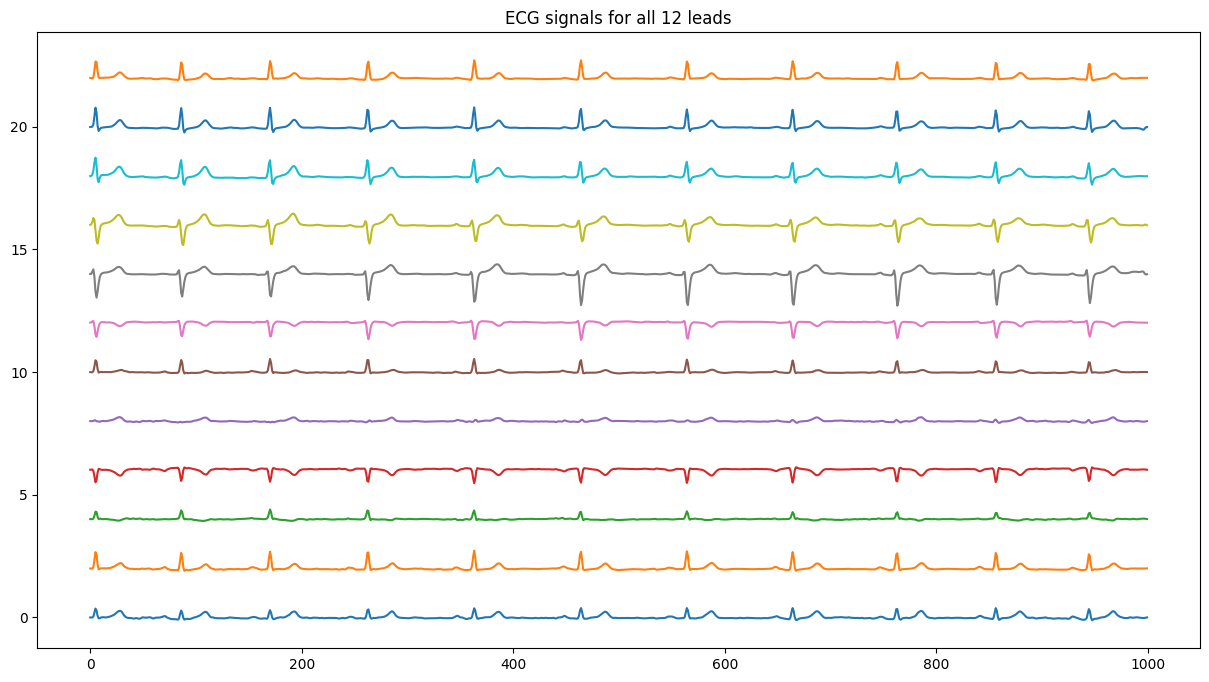

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

# Create a list to store all ECG signals
all_ecgs = []

# Iterate over the 12 leads
for i in range(12):
    single_ecg = []
    for sublist in df_encoded.loc[3,'signal']:  # Get the data for one patient
        single_ecg.append(sublist[i])  # Get data for one lead

    signals, info = nk.ecg_process(single_ecg, sampling_rate=100)
    cleaned_ecg = signals["ECG_Clean"]

    all_ecgs.append(cleaned_ecg)

# Combine all ECG signals into a single 2D array
all_ecgs = np.stack(all_ecgs)

# Plot each ECG lead with a slight vertical shift for better visibility
for i, ecg in enumerate(all_ecgs):
    plt.plot(ecg + i*2)  # Shift each lead by 200 units

plt.title('ECG signals for all 12 leads')
plt.show()


## Remove last beat if incomplete

In [72]:
# cpt=0
# def clean_heartbeats(row):
#     global cpt
#     all_leads = []
#     for sublist in row['signal']:
#         all_leads.append(sublist)  # Get all leads 

#     # Process lead II to get R-peaks
#     single_ecg_lead_II = [sublist[1] for sublist in row['signal']]  # LEAD II 
#     try:
#         signals, info = nk.ecg_process(single_ecg_lead_II, sampling_rate=100)
#     except ValueError as e:
#         print(f"An error occurred while processing the ECG data for record {row['record_name']}: {e}")
#         return single_ecg_lead_II  # Return the original ECG signal if an error occurs

#     rpeaks = info["ECG_R_Peaks"]
#     # Remove NaN values from rpeaks
#     rpeaks = rpeaks[~np.isnan(rpeaks)]
#     try:
#         heartbeats_II = np.split(single_ecg_lead_II, rpeaks.astype(int))
#     except ValueError as e:
#         print(f"An error occurred while splitting the ECG data for record {row['record_name']}: {e}")
#         return single_ecg_lead_II  # Return the original ECG signal if an error occurs

#     # Check if the last heartbeat is incomplete (i.e., significantly shorter than the others)
#     average_heartbeat_length = np.mean([len(heartbeat) for heartbeat in heartbeats_II])
#     if len(heartbeats_II[-1]) < average_heartbeat_length * 0.75:
#         rpeaks = rpeaks[:-1]  # Remove the last R-peak
#         cpt += 1

#     # Use the R-peaks to segment all leads and remove incomplete heartbeats
#     cleaned_ecg_leads = []
#     for lead in all_leads:
#         try:
#             heartbeats = np.split(lead, rpeaks.astype(int))
#         except ValueError as e:
#             print(f"An error occurred while splitting the ECG data for record {row['record_name']}: {e}")
#             return lead  # Return the original ECG signal if an error occurs

#         if len(heartbeats[-1]) < average_heartbeat_length * 0.75:
#             heartbeats = heartbeats[:-1]  # Remove the last heartbeat if incomplete
#         # Concatenate the heartbeats back into a single ECG signal
#         cleaned_ecg_lead = np.concatenate(heartbeats)
#         cleaned_ecg_leads.append(cleaned_ecg_lead)

#     # Stack the cleaned leads back together
#     cleaned_ecg = np.stack(cleaned_ecg_leads, axis=-1)
#     return cleaned_ecg


# # Apply the function to the 'signal' column of the DataFrame
# df_encoded_removed_beats = df_encoded
# df_encoded_removed_beats['signal'] = df_encoded.apply(clean_heartbeats, axis=1)
# print(df_encoded_removed_beats)
# print(df_encoded_removed_beats['signal'][0])
# print(df_encoded_removed_beats['signal'][0][0])
# print(df_encoded_removed_beats['signal'][0][0][0])
# print(df_encoded_removed_beats.shape)
# print(f"number of incomplete beats patients: {cpt}/{len(df_encoded.index)}")
# df_encoded_removed_beats.to_pickle('df_encoded_removed_beats.pkl')



## Notch filer - 50hz cleaning

In [73]:
# # Define the sample rate and the frequencies for the notch and low-pass filters
# sample_rate = 100
# notch_freq = 50
# low_pass_freq = 15  # Adjust the low-pass frequency to maintain similar filtering characteristics

# def design_filters(sample_rate, notch_freq, low_pass_freq):
#     # Design the notch filter
#     nyquist = 0.5 * sample_rate
#     freq_ratio = notch_freq / nyquist
#     notch_filter = iirnotch(freq_ratio, 30)  # 30 is the quality factor of the filter

#     # Design the low-pass filter
#     low_pass_filter = butter(5, low_pass_freq / nyquist, btype='low')

#     return notch_filter, low_pass_filter

# # Design the filters
# notch_filter, low_pass_filter = design_filters(sample_rate, notch_freq, low_pass_freq)
# # Define a function to apply the filters
# def apply_filters(data, notch_filter, low_pass_filter):
#     # Apply the notch filter
#     data = lfilter(*notch_filter, data)

#     # Apply the low-pass filter
#     data = lfilter(*low_pass_filter, data)

#     return data
# # Apply the filters to the data
# print(df_encoded.shape)
# df_encoded['signal'] = df_encoded['signal'].apply(lambda signal: apply_filters(signal, notch_filter, low_pass_filter))
# print(df_encoded.shape)


## Smoothen signal cleaning

In [74]:
# # def moving_average(signal, window_size):
# #     # If the signal has more than one channel, apply the moving average to each channel
# #     if signal.ndim > 1:
# #         return np.array([np.convolve(channel, np.ones(window_size) / window_size, mode='same') for channel in signal.T]).T
# #     # If the signal is only one channel, apply the moving average normally
# #     else:
# #         return np.convolve(signal, np.ones(window_size) / window_size, mode='same')

# # df_encoded['signal'] = df_encoded['signal'].apply(lambda signal: moving_average(signal, window_size=3))

# # df_encoded['signal'] = df_encoded['signal'].apply(lambda signal: butter_lowpass_filter(signal, cutoff, fs, order))

# import pywt
# from scipy.stats import median_abs_deviation as mad

# def maddest(d, axis=None):  # Mean Absolute Deviation
#     return np.mean(np.absolute(d - np.mean(d, axis)), axis)

# def wavelet_smooth(signal, wavelet="db5", level=1):
#     coeff = pywt.wavedec(signal, wavelet, mode="per")
#     sigma = (1/0.6745) * maddest(coeff[-level])
#     uthresh = sigma * np.sqrt(2*np.log(len(signal)))
#     coeff[1:] = (pywt.threshold(i, value=uthresh, mode="soft") for i in coeff[1:])
#     reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per")
#     return reconstructed_signal

# df_encoded['signal'] = df_encoded['signal'].apply(lambda signal: wavelet_smooth(signal))



## Remove Outliers

In [75]:

# # Compute the mean and standard deviation for each record
# means = np.array([np.mean(record) for record in df_encoded['signal']])
# std_devs = np.array([np.std(record) for record in df_encoded['signal']])

# # Compute the average mean and standard deviation
# avg_mean = np.mean(means)
# avg_std_dev = np.mean(std_devs)

# # Compute the standard deviation of the means and standard deviations
# std_mean = np.std(means)
# std_std_dev = np.std(std_devs)

# # Identify outliers as records where the mean or standard deviation is more than 3 standard deviations from the average
# outlier_indices = np.where(
#     (np.abs(means - avg_mean) > 3 * std_mean) | 
#     (np.abs(std_devs - avg_std_dev) > 3 * std_std_dev)
# )[0]

# # Remove outliers from df
# df_cleaned = df_encoded.drop(outlier_indices)
# print(df_cleaned.shape)
# print(len(df_cleaned['signal'][0]))
# print(df_cleaned['signal'][0][0])
df_cleaned = df_encoded

## Normalization

In [76]:
# from tqdm import tqdm

# def normalize_patient_signals(patient_signals, patient_index):
#     scaler = MinMaxScaler(feature_range=(-1, 1))
#     patient_ecgs_normalized = []
    
#     for i in range(12):
#         single_ecg = patient_signals[:, i]
        
#         try:
#             signals, info = nk.ecg_process(single_ecg, sampling_rate=100)
#             cleaned_ecg = signals["ECG_Clean"]

#             # Normalize the ECG signal
#             normalized_ecg = scaler.fit_transform(cleaned_ecg.to_numpy().reshape(-1, 1))

#             # Center the normalized ECG signal around 0
#             normalized_centered_ecg = normalized_ecg - np.mean(normalized_ecg)
#             patient_ecgs_normalized.append(normalized_centered_ecg.flatten())

#         except ValueError:
#             print(f"Error processing ECG signal for patient at index {patient_index}. Plotting signal and skipping...")
#             plt.figure(figsize=(10, 4))
#             plt.plot(single_ecg)
#             plt.title(f'ECG signal causing error for patient at index {patient_index}')
#             plt.show()
#             return None  # Return None to indicate an error

#     # Combine all normalized ECG signals for current patient into a single 2D array
#     return np.stack(patient_ecgs_normalized)


# # Apply the function to each row in the 'signal' column, and also pass the index to the function
# for index in tqdm(df_encoded.index):
#     df_encoded.at[index, 'signal'] = normalize_patient_signals(df_encoded.loc[index, 'signal'], index)

# # Drop rows where 'signal' is None (i.e., the ECG processing failed)
# df_encoded = df_encoded.dropna(subset=['signal'])
# df_cleaned = df_encoded


# Split

In [77]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate the target labels (heart condition classes) and the input features
X_ecg = np.array(df_cleaned['signal'].tolist())
X_info = df_cleaned[[]]  # age and sex as additional features
y = df_cleaned.drop(['record_name', 'signal', 'age', 'sex'], axis=1)

# Split the data into training, validation, and test sets
X_ecg_train, X_ecg_test, X_info_train, X_info_test, y_train, y_test = train_test_split(
    X_ecg, X_info, y, test_size=0.3, random_state=42
)
X_ecg_val, X_ecg_test, X_info_val, X_info_test, y_val, y_test = train_test_split(
    X_ecg_test, X_info_test, y_test, test_size=0.5, random_state=42
)

# Apply feature scaling (if needed) on the ECG signal data
# scaler = StandardScaler()
# X_ecg_train = np.array([scaler.fit_transform(sample) for sample in X_ecg_train])
# X_ecg_val = np.array([scaler.transform(sample) for sample in X_ecg_val])
# X_ecg_test = np.array([scaler.transform(sample) for sample in X_ecg_test])

# Check the shapes of the datasets
print("ECG Data Shapes:")
print("Training data:", X_ecg_train.shape)
print("Validation data:", X_ecg_val.shape)
print("Test data:", X_ecg_test.shape)
print("\nInfo Data Shapes:")
print("Training data:", X_info_train.shape)
print("Validation data:", X_info_val.shape)
print("Test data:", X_info_test.shape)
print("\nTarget Labels Shape:")
print("Training labels:", y_train.shape)
print("Validation labels:", y_val.shape)
print("Test labels:", y_test.shape)


ECG Data Shapes:
Training data: (8570, 1000, 12)
Validation data: (1837, 1000, 12)
Test data: (1837, 1000, 12)

Info Data Shapes:
Training data: (8570, 0)
Validation data: (1837, 0)
Test data: (1837, 0)

Target Labels Shape:
Training labels: (8570, 5)
Validation labels: (1837, 5)
Test labels: (1837, 5)


# CNN 


In [78]:
# Define the ECG branch of the model
ecg_input = layers.Input(shape=(1000, 12))
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_input)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_layer)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Dropout(0.5)(ecg_layer)
ecg_layer = layers.Flatten()(ecg_layer)


# Add a couple of Dense layers
output = layers.Dense(64, activation='relu')(ecg_layer)
output = layers.Dropout(0.5)(output)
output = layers.Dense(y_train.shape[1], activation='softmax')(output)

# Build the model
model = tf.keras.Model(inputs=[ecg_input], outputs=output)


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000, 12)]        0         
                                                                 
 conv1d_2 (Conv1D)           (None, 994, 64)           5440      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 331, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 325, 64)           28736     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 108, 64)           0         
 g1D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 108, 64)           0   

In [80]:
print("Training data:", X_ecg_train.shape)
print("Validation data:", X_ecg_val.shape)
print("Test data:", X_ecg_test.shape)

#class_weight = {0: 0.3, 1: 1., 2: 0.3, 3: 0.15, 4: 0.3}

history = model.fit(
    X_ecg_train, 
    y_train, 
    validation_data=(X_ecg_val, y_val),
    epochs=10,  # specify the number of epochs
    batch_size=32,  # specify your batch size
    #class_weight = class_weight
)

Training data: (8570, 1000, 12)
Validation data: (1837, 1000, 12)
Test data: (1837, 1000, 12)
Epoch 1/10
268/268 [==============================] - 20s 69ms/step - loss: 0.8205 - categorical_accuracy: 0.7014 - val_loss: 0.7541 - val_categorical_accuracy: 0.7246
Epoch 2/10
268/268 [==============================] - 18s 66ms/step - loss: 0.6950 - categorical_accuracy: 0.7490 - val_loss: 0.7269 - val_categorical_accuracy: 0.7392
Epoch 3/10
268/268 [==============================] - 17s 64ms/step - loss: 0.6128 - categorical_accuracy: 0.7734 - val_loss: 0.7079 - val_categorical_accuracy: 0.7599
Epoch 4/10
268/268 [==============================] - 16s 61ms/step - loss: 0.5601 - categorical_accuracy: 0.7945 - val_loss: 0.6777 - val_categorical_accuracy: 0.7588
Epoch 5/10
268/268 [==============================] - 16s 61ms/step - loss: 0.5201 - categorical_accuracy: 0.8093 - val_loss: 0.7797 - val_categorical_accuracy: 0.7311
Epoch 6/10
268/268 [==============================] - 16s 59ms/ste

In [84]:
from sklearn.metrics import roc_auc_score, classification_report

# Ensure your data is correctly shaped. If your data preparation step is correct,
# X_ecg_test should already have the shape of (num_instances, 1000, 12).
# In case it doesn't, reshape it as necessary.

# Predict with the reshaped data
y_pred = model.predict(X_ecg_test)

# Convert the predictions from probabilities to binary outputs (0 and 1)
# This is necessary for multi-label classification
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred, average='samples')  # Multi-label case
print(f'ROC AUC Score: {roc_auc}')

# Classification Report
# ['CD']	['HYP']	['MI']	['NORM']	['STTC']
target_names = ['CD','HYP','MI','NORM','STTC']
print(classification_report(y_test, y_pred_binary, target_names=target_names))


58/58 [==============================] - 2s 35ms/step
ROC AUC Score: 0.9127653783342407
              precision    recall  f1-score   support

          CD       0.81      0.76      0.79       275
         HYP       0.85      0.98      0.91       381
          MI       0.78      0.64      0.70       341
        NORM       0.79      0.76      0.78       491
        STTC       0.78      0.60      0.68       349

   micro avg       0.81      0.75      0.78      1837
   macro avg       0.80      0.75      0.77      1837
weighted avg       0.80      0.75      0.77      1837
 samples avg       0.75      0.75      0.75      1837



C:\Users\laure\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Test

In [85]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_ecg_val, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


58/58 [==============================] - 1s 16ms/step - loss: 7.0726 - categorical_accuracy: 0.2014
Test Loss: 7.072554588317871
Test Accuracy: 0.20141534507274628


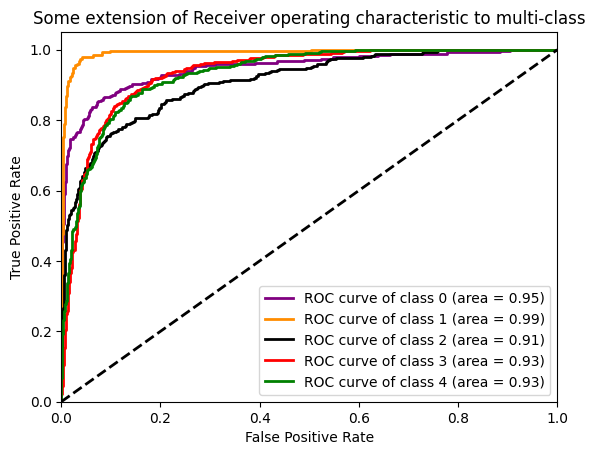

In [83]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

y_test_array = y_test.values

n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_array[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Plot all ROC curves
plt.figure()
for i, color in zip(range(n_classes), cycle(['purple', 'darkorange', 'black', 'red', 'green'])):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


## 5-Fold


In [ ]:
# from sklearn.model_selection import KFold

# # Define the number of folds
# n_folds = 5
# kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# # Define your data
# X = np.array(df_cleaned['signal'].tolist())
# y = df_cleaned.drop(['record_name', 'signal', 'age', 'sex'], axis=1)

# # Define your model
# # model = ...

# scores = []

# for train_index, val_index in kfold.split(X):
#     X_train, X_val = X[train_index], X[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
#     # Reshape data if needed and preprocess, for instance using your Scaler
#     # X_train = ...
#     # X_val = ...
    
#     # Fit the model
#     # model.fit(X_train, y_train)
    
#     # Evaluate the model
#     # score = model.evaluate(X_val, y_val)
#     # scores.append(score)

# # scores now contains your validation scores for each fold of the cross-validation
# # you can compute the average (and possibly standard deviation) of these scores to get a sense of how stable your model is across different folds


todo: 
 - complete preprocessing -> normalization, Noise Reduction, Outlier Removal,Data Augmentation,downsampling, invert? 
 - convert signal to spectogram 2D? (not 1D CNN raw data anymore, can be generated with STFT, 2D CNN) 1D simpler but 2D may perform better
 - remove diseases because accuracy is poor
 - rajouter age et sexe?
 - CNN prep, build, model train, evaluate
 - RNN
 - Transofrmer

balancer le dataset
checker la normalisation

Done:
- remove last beat (when 0 volt)

tests with basic CNN, 1000 premiers:
- no normalize, no removal beat : 
- normalized, removed beat: 0.5
- normalized, no removed beat: 
- no normalized, removed beat: 0.51 (problem in normalization?)

